In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df= pd.read_csv('/Users/burakfindikli/Documents/repos/ML_Analiz/data/2018-2019_tsl.csv',index_col = False)
df2=pd.read_csv('/Users/burakfindikli/Documents/repos/ML_Analiz/data/2018-2019_tsl.csv',index_col = False)

In [27]:
#  2017-2018 ile 2018-2019 sezonunun Maçlarını birleştirdim
df3=pd.concat([df, df2], ignore_index=True)


In [28]:
#Maçı ev sahibi kazandıysa 1 beraberlik olduysa 0 deplasman takımı kazandıysa 2 diye kodladım.
df3["kazanan_dep"]=df3.ev_sonuc < df3.dep_sonuc
df3.kazanan_dep = df3.kazanan_dep.astype(int)*2

df3["kazanan_ev"] = df3.ev_sonuc > df3.dep_sonuc
df3.kazanan_ev = df3.kazanan_ev.astype(int)

df3["kazanan_berabere"] = df3.ev_sonuc == df3.dep_sonuc
df3.kazanan_berabere = df3.kazanan_berabere.astype(int)*0

df3["sonuc"]=df3.kazanan_dep+df3.kazanan_ev+df3.kazanan_berabere
df3=df3.drop(['kazanan_dep', 'kazanan_ev','kazanan_berabere','ev_gol','dep_gol'], axis=1)
del(df,df2)

In [29]:
#bu değişkenlerde % ve , var temizleme yapmam lazım
col=['ev_topla_oynama','ev_ikili_mucadele_kazanma','ev_hava_topu','dep_topla_oynama','dep_ikili_mucadele_kazanma','dep_hava_topu','ev_pas_isabet','ev_rakip_yari_sahada_pas_isabeti','ev_orta_istabeti','dep_pas_isabet','dep_rakip_yari_sahada_pas_isabeti','dep_orta_istabeti','ev_sut_isabeti','dep_sut_isabeti','ev_top_kapma_basarisi','dep_top_kapma_basarisi']

In [30]:
# col değişkenindeki % , gibi karakterleri replace ettim
k=0
while k < df3[col].shape[1]:
    df3[col[k]] = df3[col[k]].str.replace(",",".")
    df3[col[k]] = df3[col[k]].str.replace("%","")
    k+=1

In [31]:
#object olan veri tiplerini floata çevirdim
df3[col]=df3[col].astype(float)

In [32]:
drop_value = ['ev_takim', 'dep_takim', 'ev_sonuc', 'dep_sonuc', ]
df3=df3.drop(drop_value,axis=1)

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
#bağımlı bağımsız değişkenlerimi ayırdım 
#bağımlı değişken sonuc(1=Evsahibi kazanır 0=Beraberlik 2=Deplasman kazanır)
x = df3.iloc[:,:-1]
y = df3.sonuc
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
x_scaled = stdsc.fit_transform(x)
X_train, X_test, y_train, y_test = train_test_split(x_scaled,y,test_size=0.2,random_state=101)

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import time

In [36]:
start = time.process_time()
model = RandomForestClassifier(n_estimators=700).fit(X_train,y_train)
print(time.process_time()-start)

4.370889000000002


In [37]:
preds = model.predict(X_test)

In [38]:
print(confusion_matrix(y_test,preds))

[[109  10   2]
 [  4 210   4]
 [  0  14 123]]


In [39]:
model.score(X_test,y_test)

0.9285714285714286

In [40]:
model.feature_importances_

array([0.02049464, 0.02171279, 0.02035733, 0.01678686, 0.01107572,
       0.01375147, 0.02057002, 0.02102858, 0.02057109, 0.01744813,
       0.01067823, 0.01299372, 0.02183549, 0.0172081 , 0.02408273,
       0.02658721, 0.03225172, 0.02047568, 0.02326854, 0.02380764,
       0.02389359, 0.02389594, 0.02293783, 0.02072353, 0.01651626,
       0.03687261, 0.01216526, 0.01550247, 0.02542168, 0.05577374,
       0.01686368, 0.03526341, 0.01002013, 0.01504725, 0.02499614,
       0.04093258, 0.01640143, 0.01873116, 0.03093473, 0.0173115 ,
       0.01994013, 0.04214572, 0.0153165 , 0.0108169 , 0.00410148,
       0.0158415 , 0.00996519, 0.00468198])

In [41]:
feature_imp = pd.Series(model.feature_importances_, index = x.columns)

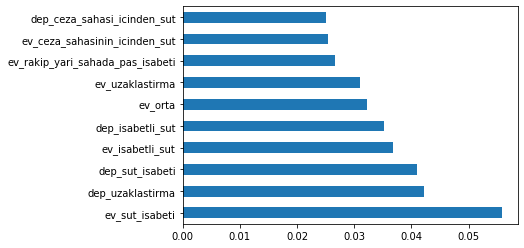

In [42]:
feature_imp.nlargest(10).plot(kind='barh')

In [43]:
best_feature = feature_imp.nlargest(6).index.to_list()

In [44]:
x_reduced = x[best_feature]

In [45]:
xr_scaled = StandardScaler().fit_transform(x_reduced)

In [46]:
Xr_train, Xr_test, yr_train, yr_test = train_test_split(xr_scaled,y,test_size=0.2)

In [47]:
start = time.process_time()
rmodel = RandomForestClassifier(n_estimators=700).fit(Xr_train,yr_train)
print(time.process_time()-start)

2.6318659999999987


In [48]:
rpred = rmodel.predict(Xr_test)
print(confusion_matrix(yr_test,rpred))
print(classification_report(yr_test,rpred))

[[ 97   8   2]
 [  2 210   8]
 [ 10  16 123]]
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       107
           1       0.90      0.95      0.93       220
           2       0.92      0.83      0.87       149

    accuracy                           0.90       476
   macro avg       0.90      0.90      0.90       476
weighted avg       0.90      0.90      0.90       476

